In [1]:
import os, sys
import importlib
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('c:\\main\\Work\\thesis\\Bachelor-Thesis\\Code\\hierarchical-clustering\\hierarchical_clustering.py'))))
import matplotlib.pyplot as plt
import pickle as pkl
import gc
import numpy as np
from treelib import Node, Tree
from timit.loading import Feature_Collector
from lib.conceptors import *
from lib.esn import ESN
from lib.helpers import *
from lib.plot import Plot
import warnings
warnings.filterwarnings("ignore")

###-------------- Collecting Training Features -------------------
path = '../timit/'
fc = Feature_Collector(path)

save = True

dr = []
speakers = []
long_version = False
n_mels = 10
delta = False
delta_delta = False
subsamples = 4
fc.readTrainingDataDescriptionCSV()
speakers = fc._Tdd.speaker_id.unique()
speakers = np.random.choice(speakers,100,replace=False)
sentence = "SX"

path_option = str(long_version)+"_"+str(n_mels)+"_"+str(delta)+"_"+str(delta_delta)+"_"+str(subsamples)

if dr:
    path_option = str(dr)+"_"+path_option
if len(speakers):
    path_option = str(speakers[0])+"_"+path_option

features,labels,oversamplings = fc.collectFeaturesInSegments(
    n_mels=n_mels,delta=delta,delta_delta=delta_delta,
    long_version=long_version,speakers=speakers,dr=dr,
    subsamples=subsamples,path_option=path_option)

gc.collect()

--- Failed
1000
0
100
200
300
400
500
600
700
800
900
--- Completed


0

In [2]:
# init reservoir
import random
random.seed(0)
np.random.seed(0)
t_washout = 0 # number of washout steps
aperture = 5
nb_trials = 1

esn_params = {
    "in_dim": n_mels*(1+delta+delta_delta),
    "out_dim": n_mels*(1+delta+delta_delta),
    "N": 20,
    "W_in_scale": 1.5,
    "b_scale": .2,
    "spectral_radius": 1.5
}

esn = ESN(esn_params)

In [3]:
group = {}
selected_labels = ["aa", "ae", "ah", "eh", "ih", "iy", "uh"]
# { phoneme : samples }, where the samples = [ [x[0],x[1]...], [] ]
for i in range(len(features)):
    if labels[i] not in selected_labels:
        continue
    if labels[i] not in group.keys():
        group[labels[i]] = []
    group[labels[i]].append(features[i])
print(len(group.keys()))
min_samples = max([len(samples) for samples in group.values()])

phonemes = list(group.keys())
print(min_samples)
print(str(len(phonemes))+" phonemes")
print(phonemes)
#[print(x," ss ",len(y)) for x,y in group.items() ]

7
2985
7 phonemes
['ih', 'aa', 'iy', 'eh', 'ah', 'uh', 'ae']


In [4]:
save = False
params = str(aperture)+"_"+str(esn_params["N"])+"_"+str(min_samples)

file_name = "_"+params+"_"+path_option+"_"+str(selected_labels)

if save and os.path.exists('./cache/working/'+"Cs"+file_name+'.pkl') and os.path.exists('./cache/working/'+"Ns"+file_name+'.pkl'):
    print("- loading conceptors from file")
    Cs_fp = open('./cache/working/'+"Cs"+file_name+'.pkl','rb')
    Cs = pkl.load(Cs_fp)
    Cs_fp.close()
    Ns_fp = open('./cache/working/'+"Ns"+file_name+'.pkl','rb')
    Ns = pkl.load(Ns_fp)
    Ns_fp.close()
    print("--- Done")
else:
    print("- computing conceptors")
    Cs = []
    Cs_labels = []
    all_signals = []
    for phoneme, signals in group.items():
        print(phoneme," - ", len(signals), " samples")
        for signal in signals:
            x,_ = esn.run_X(signal.T,0,signal.shape[0])
            Cs.append(compute_c(x, aperture))
            Cs_labels.append(phoneme)
            all_signals.append(signal)
    print("- computing negative conceptors")
    #Ns = Ns_from_Cs(Cs)
    print("- optimizing +")
    Cs = optimize_apertures(Cs)
    print("- optimizing -")    
    #Ns = optimize_apertures(Ns)
    
    if save:
        Cs_fp = open("./cache/working/"+"Cs"+file_name+".pkl",'wb')
        pkl.dump(Cs,Cs_fp)
        Cs_fp.close()
        Ns_fp = open("./cache/working/"+"Ns"+file_name+".pkl",'wb')
        pkl.dump(Ns,Ns_fp)
        Ns_fp.close()
    
    print("--- Done")

- computing conceptors
ih  -  2985  samples
aa  -  1265  samples
iy  -  1470  samples
eh  -  829  samples
ah  -  1354  samples
uh  -  113  samples
ae  -  823  samples
- computing negative conceptors
- optimizing +
- optimizing -
--- Done


In [ ]:
#------ Custom test
correct = 0
n=0
fv, lv, _ = fc.collectFeaturesInSegments(
    ft='Test',n_mels=n_mels,delta=delta,delta_delta=delta_delta,
    long_version=long_version,speakers=speakers,dr=dr,subsamples=subsamples,
    path_option=path_option+"_test")

test_group = {}
for key in group.keys():
    test_group[key] = []

for i in range(len(fv)):
    if lv[i] in group.keys():
        test_group[lv[i]].append(fv[i])

for i,y in enumerate(test_group.items()):
    for sample in y[:200]:
        z = esn.run(sample.T)
        es = evidences_for_Cs_z(z,Cs,Ns)
        es = [ np.sum(p) for p in es ]
        correct += x==list(test_group.keys())[np.argmax(es)]
        n+=1
        #print(list(group.keys())[np.argmax(es)])
print("Accuracy: ",correct/n)
print("n_mels: ",n_mels)
print("d: ",delta)
print("dd: ",delta_delta)
print("speakers: ",speakers)
print("dr: ",dr)
print("Min_samples: ",min_samples)
print("Test: ","Test")
print("subsamples: ",subsamples)
print("Neurons: ",esn_params["N"])
print("Aperture: ",aperture)

In [5]:
save = True
dist_fun = "cos"
hm_filename = "_5_40_1100_False_14_False_False_10_hm_cos"

if save and os.path.exists('./cache/working/'+hm_filename+'.pkl'):
    print("- from file")
    fp = open('./cache/working/'+hm_filename+'.pkl','rb')
    heat_map = pkl.load(fp)
    fp.close()
    print("--- Done")
else:
    print("- computing heatmap")
    heat_map = np.zeros((len(phonemes),len(phonemes)))

    for x in range(len(phonemes)):
        for y in range(0, x+1):
            sim = similarity_c(Cs[x], Cs[y])
            heat_map[x,y] = sim
            heat_map[y,x] = sim    
    if save:
        fp = open("./cache/working/"+hm_filename+".pkl",'wb')
        pkl.dump(heat_map,fp)
        fp.close()
    print("--- Done")

- from file
--- Done


In [ ]:
coll = []
hm = heat_map.copy()

for t in range(len(phonemes)**2):
    max = 0
    maxx = 0
    maxy = 0
    for x in range(hm.shape[0]):
        for y in range(0, x):
            if max < hm[x,y]:
                max = hm[x,y]
                maxx = x
                maxy = y
    coll.append((phonemes[maxx],phonemes[maxy],hm[maxx,maxy]))
    hm[maxx, maxy] = 0

for x,y,val in coll:
    print(x," ",y," ",val)

ValueError: Dimensions of Z and labels must be consistent.

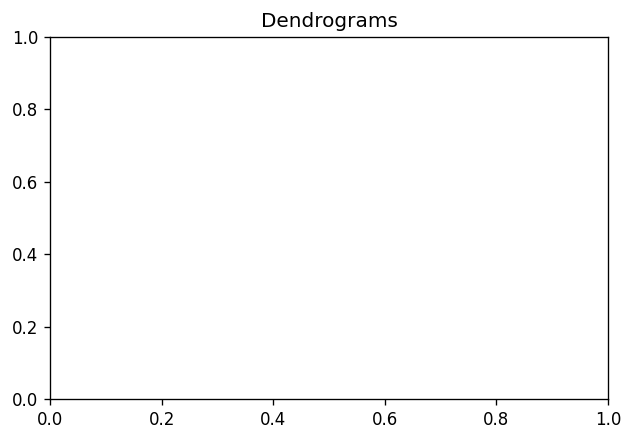

In [6]:
import scipy.cluster.hierarchy as sc
import scipy.spatial.distance as ssd

for i in range(heat_map.shape[0]):
    heat_map[i,i] = 0
distArray = ssd.squareform(heat_map)

if dist_fun == 'cos':
    distances = 1-distArray/np.max(distArray)
elif dist_fun == 'eucl':
    distances = distArray/np.max(distArray)

link = sc.linkage(distances, method='average', optimal_ordering=False)

# Plot dendrogram
plt.figure(dpi=120)
plt.title("Dendrograms")  
# Create dendrogram
sc.dendrogram(link,labels=phonemes,orientation='right',distance_sort=False)

#plt.title("Average Linkage on Phoneme Conceptors using Herbert's Distance Metric",fontsize=15)
plt.ylabel('Phoneme',fontsize=15)
plt.xlabel(r"Distance d$(p^1, p^2)=1-\frac{sim(C^1,C^2)}{max_{i,j}sim(C^i,C^j)}$",fontsize=15)
plt.show()

In [9]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches
plt.figure(figsize=(17,15),dpi=200)
sns.set_theme()

ticklabels=phonemes
print(phonemes)
sns.set(font_scale=2)
labs = ['dh','v',"h#",'k','t','p','hh','g','d','b','dx','ah','ih','uw','ey','iy','eh','ae','ay','ow','aa','er','r','l','w','ng','n','m','y','z','s','sh','jh','f']
labs = ['g','d',"b",'dx','hh','dh','hh','g','d','b','dx','ah','ih','uw','ey','iy','eh','ae','ay','ow','aa','er','r','l','w','ng','n','m','y','z','s','sh','jh','f']

print(len(labs),len(phonemes))
reorder = [ phonemes.index(lab) for lab in labs]
hm = heat_map[reorder,:]
hm = hm[:,reorder]
ax = sns.heatmap(hm, xticklabels=labs, yticklabels=labs, linewidths=.5, center=np.mean(heat_map)-.06)

plt.rc('xtick', labelsize='20')    # fontsize of the tick labels
plt.rc('ytick', labelsize='20')

recs = [
    [1,1]
    
]

for rec in recs:
    ax.add_patch(
         patches.Rectangle(
             (rec[0], rec[0]),
             rec[1],
             rec[1],
             edgecolor='blue',
             fill=False,
             lw=5
         ) )

plt.xticks(rotation=0)
plt.yticks(rotation=0)

plt.show()

['h#', 'w', 'ih', 's', 'ah', 'ch', 'n', 'ae', 't', 'v', 'r', 'f', 'y', 'uw', 'sh', 'l', 'b', 'iy', 'aa', 'd', 'eh', 'p', 'z', 'ey', 'dx', 'ay', 'ng', 'k', 'dh', 'er', 'm', 'jh', 'g', 'ow', 'aw', 'hh', 'uh', 'oy', 'th']
34 39


IndexError: index 35 is out of bounds for axis 0 with size 34

<Figure size 3400x3000 with 0 Axes>

In [5]:
import matplotlib.pyplot as plt
from math import floor
from matplotlib import gridspec

"""
Problem-specific plotting
"""
class Plot:
    def __init__(self, x, y):
        plt.rcParams["figure.autolayout"] = True
        self.fig = plt.figure(figsize=(y,x))
        self.cnt = 0
        self.new_ax = None

    def add(self, y, label=None):
        if label != None:
            self.new_ax.plot(y, label=label)
            self.new_ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),
                                 ncol = 2, fancybox=True, shadow=True,
                                 handleheight=2.4, labelspacing=0.05)
        else:
            self.new_ax.plot(y)

    def inc(self):
        """Plots the data to a new subplot at the bottom."""
        self.cnt += 1
        gs = gridspec.GridSpec(self.cnt, 1)

        # Reposition existing subplots
        for i, ax in enumerate(self.fig.axes):
            ax.set_position(gs[i].get_position(self.fig))
            ax.set_subplotspec(gs[i])

        # Add new subplot
        self.new_ax = self.fig.add_subplot(gs[self.cnt-1])
        
        
    def add_new(self, y, label="No Label"):
        self.inc()
        self.add(y, label)

    def add_new_assignment_plot(self, assignments, labels=[], fuzzy=False, length=0):
        self.inc()
        for idx, ts in enumerate(assignments):
            if not fuzzy:
                y = []
                if length == 0:
                    length = max( [ max(ts) for ts in assignments if ts != [] ] )
                for t in range(length):
                    if t in ts:
                        y.append(1)
                    else:
                        y.append(0)
            else:
                y = ts
            if max(y) > 0:
                if labels == None:
                    self.add(smoothed(y,1))
                elif labels == []:
                    self.add(smoothed(y, 1), idx)
                else:
                    self.add(smoothed(y, 1), str(labels[idx]))


    def add_new_conceptors_fit_plot(self, X, Cs, Ns=None, label="", labels=""):
        """
        Plots, for each time step t, how well each conceptor in Cs matches the state x(t)
        """
        self.inc()
        if Ns:
            collection = evidences_for_Cs(X,Cs,Ns)
        else:
            collection, _ = test(X, Cs, "PROP")
        if labels:
            for vals, label in zip(collection, labels):
                # walking average of d
                self.add(smoothed(vals, 3), label=label)
        else:                
            for i, vals in enumerate(collection):
                # walking average of d
                self.add(smoothed(vals, 3), label=label+str(i))


    def finalize(self, title=""):
        self.fig.suptitle(title, fontsize=16)
        plt.show()

In [19]:
all_signals = []
for phoneme, signals in group.items():
    for signal in signals:
        all_signals.append(signal)
print(len(all_signals))


8981


In [ ]:
### Kmeans helpers

def assign_to_clusters_fixed(nb_points, nb_clusters):
    """
    Assigns points to conceptors according to one of several assignment methods
    Returns [[points in cluster 1], [points in cluster 2], ...]
    """
    assignments = [ [] for _ in range(nb_clusters) ]
    points = [ x for x in range(nb_points) ]
    np.random.shuffle(points)
    for i in range(nb_clusters):
        assignments[i] = points[i*int(nb_points/nb_clusters):(i+1)*int(nb_points/nb_clusters)]
    return assignments


def F(assignments, correct_assignments):
    overlaps = np.zeros((len(assignments), len(correct_assignments))) # (Cs x phonemes)

    for i1, assignment in enumerate(assignments):
        for a in assignment:
            for i2, correct_assignment in enumerate(correct_assignments):
                if a in correct_assignment:
                    overlaps[i1, i2] += 1

    dic = []
    cnt = 0
    for _ in range(len(correct_assignments)):
        i1, i2 = np.unravel_index(overlaps.argmax(), overlaps.shape)
        dic.append(i1)
        cnt += overlaps[i1,i2]
        overlaps[i1,:] = np.zeros((1,len(correct_assignments)))
        overlaps[:,i2] = np.zeros((len(assignments),))

    return cnt/max([ max(ass) for ass in assignments if ass != [] ])


idx=0
correct_assignments = [ [] for _ in group.values() ]
for i,vals in enumerate(group.values()):
    for val in vals:
        correct_assignments[i].append(idx)
        idx += 1

In [ ]:
####################
# Kmeans
# with Evidences
####################


def k_means_fixed(features, nb_clusters, max_epochs, new_assignments=None):
    nb_points = len(features)
    if new_assignments == None:
        new_assignments = assign_to_clusters_fixed(nb_points, nb_clusters)
    
    for epoch in range(max_epochs):
        print("epoch:",epoch)
        Cs_kmeans = []
        for assignments in new_assignments:
            if assignments != []:
                X = np.array([])
                for a in assignments:
                    x,_ = esn.run_X(all_signals[a].T,0,all_signals[a].shape[0])
                    X = np.hstack((X, x)) if X.size else x
                Cs_kmeans.append(compute_c(X, aperture))
        Ns_kmeans = Ns_from_Cs(Cs) 
        Cs = optimize_apertures(Cs)
        Ns = optimize_apertures(Ns)
        old_assignments = new_assignments.copy()
        new_assignments = [ [] for _ in range(len(Cs_kmeans)) ]
        for p in range(nb_points):
            x,_ = esn.run_X(all_signals[p].T,0,all_signals[p].shape[0])
            es = evidences_for_Cs(x,Cs,Ns)
            es = [ np.sum(p) for p in es ]
            conceptor_index = np.argmax(es)
            new_assignments[ conceptor_index ].append(p)
        
        for new_assignment in new_assignments:
            stop = False
            for old_assignment in old_assignments:
                if set(new_assignment) == set(old_assignment):
                    stop = True
            if stop:
                print("Converged")
                return Cs, new_assignments
    return Cs_kmeans, new_assignments

Cs_kmeans, assignments_kmeans = k_means_fixed(Cs,len(phonemes),15)

print(F(assignments_kmeans, correct_assignments))

In [20]:
####################
# Kmeans
# Disjunction and similarities
####################


def k_means_fixed(features, nb_clusters, max_epochs, new_assignments=None):
    nb_points = len(features)
    if new_assignments == None:
        new_assignments = assign_to_clusters_fixed(nb_points, nb_clusters)
    
    for epoch in range(max_epochs):
        print("epoch:",epoch)
        Cs_kmeans = []
        for assignments in new_assignments:
            if assignments != []:
                C = features[assignments[0]]
                for a in assignments:
                    C = OR_C( C, features[a] )
                Cs_kmeans.append(C)
        old_assignments = new_assignments.copy()
        new_assignments = [ [] for _ in range(len(Cs_kmeans)) ]
        for p in range(nb_points):
            similarities = [ similarity_c(C,features[p]) for C in Cs_kmeans ]
            conceptor_index = np.argmax(similarities)
            new_assignments[ conceptor_index ].append(p)
        
        for new_assignment in new_assignments:
            stop = False
            for old_assignment in old_assignments:
                if set(new_assignment) == set(old_assignment):
                    stop = True
            if stop:
                print("Converged")
                return Cs, new_assignments
    return Cs_kmeans, new_assignments

epoch: 0
7
epoch: 1
4
epoch: 2
4
epoch: 3
4
epoch: 4
4
epoch: 5
4
epoch: 6
4
epoch: 7
4
epoch: 8
4
epoch: 9
4
epoch: 10
4
epoch: 11
4
epoch: 12
4
epoch: 13
4
epoch: 14
4


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
####################
# Kmeans
# Disjunction and abstraction
####################


def k_means_fixed(features, nb_clusters, max_epochs, new_assignments=None):
    nb_points = len(features)
    if new_assignments == None:
        new_assignments = assign_to_clusters_fixed(nb_points, nb_clusters)
    
    for epoch in range(max_epochs):
        print("epoch:",epoch)
        Cs_kmeans = []
        for assignments in new_assignments:
            if assignments != []:
                C = features[assignments[0]]
                for a in assignments:
                    C = OR_C( C, features[a] )
                Cs_kmeans.append(C)
        old_assignments = new_assignments.copy()
        new_assignments = [ [] for _ in range(len(Cs_kmeans)) ]
        for p in range(nb_points):
            similarities = [ similarity_c(C,features[p]) for C in Cs_kmeans ]
            conceptor_index = np.argmax(similarities)
            new_assignments[ conceptor_index ].append(p)
        
        for new_assignment in new_assignments:
            stop = False
            for old_assignment in old_assignments:
                if set(new_assignment) == set(old_assignment):
                    stop = True
            if stop:
                print("Converged")
                return Cs, new_assignments
    return Cs_kmeans, new_assignments

In [7]:
def assign_to_clusters(nb_points, nb_clusters):
    """
    Assigns points to conceptors according to one of several assignment methods
    Returns [[points in cluster 1], [points in cluster 2], ...]
    """
    assignments = [ [] for _ in range(nb_clusters) ]
    points = [ x for x in range(nb_points) ]
    np.random.shuffle(points)
    for i in range(nb_clusters):
        assignments[i] = points[i*int(nb_points/nb_clusters):(i+1)*int(nb_points/nb_clusters)]
    return assignments

def k_means(features, labels, nb_conceptors, max_epochs, new_assignments=None):
    """
    Kmeans algorithm, adapted to conceptors
    """
    # Initial assignments and initial conceptors
    nb_points = len(features)
    if new_assignments == None:
        new_assignments = assign_to_clusters(nb_points, nb_conceptors)
    # Training loop
    for epoch in range(max_epochs):
        print("epoch:",epoch)
        # recompute centroids based on subset of assigned state
        print("- computing conceptors")
        Cs = []
        for assignments in new_assignments:
            Z = np.array([])
            for assignment in assignments:
                z = esn.run(features[assignment].T)
                Z = np.hstack([Z, z]) if Z.size else z
            Cs.append(compute_c(Z, aperture))
        print("- computing negative conceptors")
        Ns = Ns_from_Cs(Cs)
        print("- optimizing +")
        Cs = optimize_apertures(Cs)
        print("- optimizing -")    
        Ns = optimize_apertures(Ns)

        # recompute assignments by find the closest conceptor for each of the state points
        old_assignments = new_assignments.copy()
        new_assignments = [ [] for _ in range(nb_conceptors) ]
        for p in range(nb_points):
            z = esn.run(features[p].T)    
            conceptor_index = np.argmax(np.array(evidences_for_Cs_z(z,Cs,Ns)))
            new_assignments[ conceptor_index ].append(p)

        # stop if converged
        for new_assignment, old_assignment in zip(new_assignments, old_assignments):
            if set(new_assignment) == set(old_assignment):
                print("Converged")
                return Cs, Ns, new_assignments
    return Cs, Ns, new_assignments


plot = Plot()

feats = []
labs = []

for key, val in group.items():
    feats += val
    labs += [key for _ in range(len(val))]
temp = list(zip(feats, labs))
random.shuffle(temp)
feats, labs = zip(*temp)

Cs_kmeans, Ns_kmeans, assignments = k_means(feats,labs,len(phonemes),max_epochs=15,new_assignments=assignments)

NameError: name 'assignments' is not defined

In [ ]:
sims_Cs = np.zeros((len(phonemes),len(phonemes))) # Cs x Cs_kmeans

matches = 0
for x in range(len(phonemes)):
    for y in range(len(phonemes)):
        sim = similarity_c(Cs[x], Cs_kmeans[y])
        sims_Cs[x,y] = sim

dic = {}
for _ in range(len(phonemes)):
    C, C_kmeans = np.unravel_index(sims_Cs.argmax(), sims_Cs.shape)
    dic[phonemes[C]] = C_kmeans
    overlaps[C_idx,:] = np.zeros((1,len(phoenemes)))
    overlaps[:,phoneme_idx] = np.zeros((len(phoenemes),1))

print(matches / len(phonemes))
print("Random would be 1 <3")

In [50]:
overlaps = np.zeros((len(phonemes), len(phonemes))) # (Cs x phonemes)

for C_idx, assignment in enumerate(assignments):
    for idx in assignment:
        overlaps[C_idx, phonemes.index(labs[idx])] += 1

dic = {}

for _ in range(len(phonemes)):
    C_idx, phoneme_idx = np.unravel_index(overlaps.argmax(), overlaps.shape)
    dic[phonemes[phoneme_idx]] = C_idx
    overlaps[C_idx,:] = np.zeros((1,len(phonemes)))
    overlaps[:,phoneme_idx] = np.zeros((len(phonemes),))

Cs_final = []
Ns_final = []
for phoneme in [p for p in phonemes if p in list(dic.keys()) ]:
    Cs_final.append(Cs_kmeans[dic[phoneme]])
    Ns_final.append(Ns_kmeans[dic[phoneme]])

In [51]:
#------ Custom test
correct = 0
n=0
fv, lv, _ = fc.collectFeaturesInSegments(
    ft='Test',n_mels=n_mels,delta=delta,delta_delta=delta_delta,
    long_version=long_version,speakers=speakers,dr=dr,subsamples=subsamples,
    path_option=path_option+"_test")

test_group = {}
for key in group.keys():
    test_group[key] = []

for i in range(len(fv)):
    if lv[i] in group.keys():
        test_group[lv[i]].append(fv[i])

for i,(x,y) in enumerate(test_group.items()):
    for sample in y[:200]:
        z = esn.run(sample.T)
        es = evidences_for_Cs_z(z,Cs_final,Ns_final)
        es = [ np.sum(p) for p in es ]
        correct += x==list(test_group.keys())[np.argmax(es)]
        n+=1
        #print(list(group.keys())[np.argmax(es)])

print("Accuracy: ",correct/n)
print("n_mels: ",n_mels)
print("d: ",delta)
print("dd: ",delta_delta)
print("speakers: ",speakers)
print("dr: ",dr)
print("dr: ",min_samples)
print("Test: ","Test")
print("subsamples: ",subsamples)
print("Neurons: ",esn_params["N"])
print("Aperture: ",aperture)

-from output
---- success
Accuracy:  0.17823529411764705
n_mels:  5
d:  False
dd:  False
speakers:  []
dr:  []
dr:  1100
Test:  Test
subsamples:  5
Neurons:  10
Aperture:  5
